### Clean and Package X, y Data for Model Fitting
PB 1/18/2023

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# TBD: 
# Fix PAI 
# Run kruger

# regions = ['Mpala', 'Kruger']
region = 'Mpala'

# Load X Data
metricdir = Path(f'/n/davies_lab/Lab/shared_projects/GrassBiomass/data/out/')

# Print files in folder (just for reference
# for f in metricdir.joinpath(region).glob('*'):
    # print(f)

coverd1 = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD1.csv'), index_col=0)
coverd2 = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD2.csv'), index_col=0)
coverd2byH = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD2byH.csv'), index_col=0)
complexity = pd.read_csv(metricdir.joinpath(region).joinpath('ComplexityMetrics.csv'), index_col=0)
perc = pd.read_csv(metricdir.joinpath(region).joinpath('PercentileHeights.csv'), index_col=0)
PAI = pd.read_csv(metricdir.joinpath(region).joinpath('FHPD2.csv'), index_col=0)
npulses = pd.read_csv(metricdir.joinpath(region).joinpath('Npulses.csv'), index_col=0)

# Open & Format y dataset for merging

BiomassData = pd.read_csv(Path('./data/in/Mpala2022/MpalaGrassBiomassSurveys2022Curated.csv'))

# Note need to cut some blank lines from the mpala y data file
if region == 'Mpala':
    BiomassData = BiomassData[0:193]
    
# Add id column to merge with x data later
BiomassData['id'] = BiomassData['GPS #'].apply(lambda x: int(x))

(-0.1, 2.0)

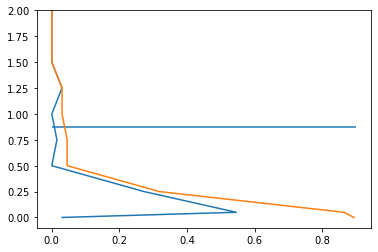

In [4]:
# Testing 
# featid = 'Mpala01-4'
# Test plot of mpala cover data
# fig, ax = plt.subplots()
# ax.plot(coverd2byH[featid], coverd2byH[featid].index)
# ax.plot(coverd2[featid], coverd2[featid].index)
# Add herbaceous layer height
# ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=0.9)
# ax.set_ylim(-0.1, 2)

In [5]:
# Make a cover within the herbaceous layer dictionary
# Uses the caluclated herbaceous layer height to only grab cover from the top and bottom of the grass layer
cherb_dict = {'featureid':[],
              'id':[],
              'coverherb_0m':[],
              'coverherb_5cm':[],
              'cover_0m':[],
              'cover_5cm':[]}

for featid in coverd2.columns:
    
    herbh = complexity[featid].loc['herbh']

    # find indices with 2 closest values to herbh
    i = np.argsort(np.abs(coverd2.index - herbh))

    coverd2.index[i[0:2]]

    # Interpolate a cover value at the herbh
    chmax = np.interp(herbh, xp=coverd2.index, fp=coverd2[featid])

    # Get cover value at bottom
    chmin = coverd2[featid].iloc[0]

    # Also, calc at ground level (0.05 m)
    chmin_ground = coverd2[featid].iloc[1]

    # Get total cover within herbaceous layer
    # test both ground and non-ground
    cherb = chmin - chmax
    cherb_ground = chmin_ground - chmax
    
    # Append to dict
    cherb_dict['featureid'].append(featid)
    cherb_dict['id'].append(int(featid.split('-')[1]))
    cherb_dict['coverherb_0m'].append(cherb)
    cherb_dict['coverherb_5cm'].append(cherb_ground)
    cherb_dict['cover_0m'].append(chmin)
    cherb_dict['cover_5cm'].append(chmin_ground)

cherb_df = pd.DataFrame(cherb_dict)
cherb_df_t = cherb_df.transpose()
cherb_df_t.columns = cherb_df['featureid']
cherb_df_t.head()

In [6]:
# Format percentile metric df for merging
perc_t = perc.transpose()
perc_t['id'] = [int(i.split('-')[-1]) for i in perc_t.index]
perc_t.head()

In [59]:
# Make complexity for Merging
complexity_t = complexity.transpose()
complexity_t['id'] = [int(i.split('-')[-1]) for i in complexity_t.index]
# complexity_t = pd.DataFrame(complexity_t)

In [99]:
# Make PAI for merging
# NOTE: undoing the /dz here (0.25) and dividing by k=0.5 (spherical leaf angle dist.)
# Also, only taking PAI values above 0.05 m 
PAI_lim = PAI.iloc[2:].applymap(lambda x: (x*0.25)/0.5)
# PAI_lim = PAI.iloc[2:]
PAI_t = PAI_lim.transpose()
PAI_t['id'] = [int(i.split('-')[-1]) for i in PAI_t.index]
# Issues with PAI.. leaving out for the moment
# PAI_t.sum(axis=1)

In [170]:
# make xy dataframe, including percentile heights and cover metrics
XYdf = pd.merge(cherb_df, BiomassData)
# Add in percentile metrics (by merging on 'id' col)
XYdf = pd.merge(XYdf, perc_t)
# Add in complexity metrics
XYdf = pd.merge(XYdf, complexity_t)
# add in PAI
# XYdf = pd.merge(XYdf, PAI_t)

# Add a log column 
XYdf['log(DryWeight)'] =  XYdf['Dry Weight Without Bag (g)'].apply(lambda x: np.log(x) if x>0 else x)

In [171]:
XYdf.columns

Index(['featureid', 'id', 'coverherb_0m', 'coverherb_5cm', 'cover_0m',
       'cover_5cm', 'Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1',
       'Height 2', 'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
       'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
       'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
       'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
       'Max Height (m)', '0', '25', '50', '75', '98', '100', 'mean', 'std',
       'nlayers', 'gapsize', 'maxpeakh', 'ptoh', 'cscore', 'FHD', 'VDR',
       'VDRpeak', 'meanpeakh', 'stdpeakh', 'cvpeakh', 'herbh',
       'log(DryWeight)'],
      dtype='object')

In [196]:
# Save (using region)
XYdf.to_csv(f'./data/out/{region}/XYdata.csv')

### Extras - Plotting, Printing metrics, etc.

In [ ]:
for f in metricdir.joinpath(region).glob('*'):
    print(f)

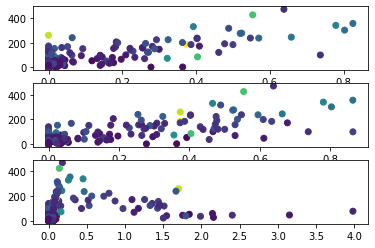

In [172]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Dry Weight Without Bag (g)
ax1.scatter(XYdf.coverherb_5cm,
            XYdf['Dry Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax2.scatter(XYdf.cover_5cm,
            XYdf['Dry Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax3.scatter(XYdf['mean'],
            XYdf['Dry Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

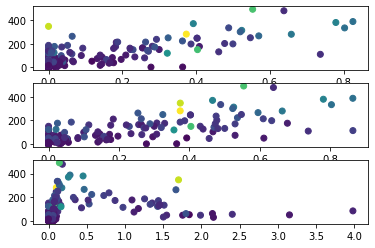

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Dry Weight Without Bag (g)
ax1.scatter(XYdf.coverherb_5cm,
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax2.scatter(XYdf.cover_5cm,
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax3.scatter(XYdf['mean'],
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

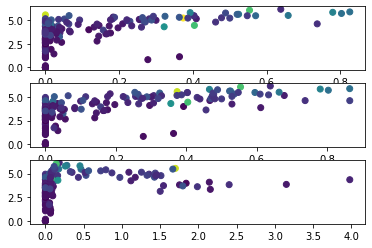

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Dry Weight Without Bag (g)
ax1.scatter(XYdf.coverherb_5cm,
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

ax2.scatter(XYdf.cover_5cm,
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

ax3.scatter(XYdf['mean'],
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

In [176]:
# MI.loc['Dry Weight Without Bag (g)']

id                            0.065380
coverherb_0m                  0.220126
coverherb_5cm                 0.376849
cover_0m                      0.236323
cover_5cm                     0.428960
Plot #                        0.065380
GPS #                         0.065380
% Cover                       0.988234
Height 1                      0.546643
Height 2                      0.537993
Height 3                      0.518524
Height 4                      0.477237
Average Height                0.997706
Wet Weight (g)                2.373469
Dry Weight (g)                3.098013
Average Bag Weight (g)        0.414207
Wet Weight Without Bag (g)    2.680078
Dry Weight Without Bag (g)         NaN
Water Weight (g)              0.641592
Max Height (cm)               0.714609
Max Height (m)                0.714609
0                             0.215749
25                            0.351851
50                            0.382393
75                            0.368826
98                       

In [177]:
# MI.loc['Wet Weight Without Bag (g)']

id                            0.073774
coverherb_0m                  0.232548
coverherb_5cm                 0.404742
cover_0m                      0.273824
cover_5cm                     0.417998
Plot #                        0.073774
GPS #                         0.073774
% Cover                       1.003916
Height 1                      0.505323
Height 2                      0.542140
Height 3                      0.565516
Height 4                      0.434456
Average Height                0.943750
Wet Weight (g)                3.162997
Dry Weight (g)                2.418681
Average Bag Weight (g)        0.448282
Wet Weight Without Bag (g)         NaN
Dry Weight Without Bag (g)    2.680078
Water Weight (g)              0.709900
Max Height (cm)               0.679562
Max Height (m)                0.679562
0                             0.231309
25                            0.310507
50                            0.374775
75                            0.396821
98                       

In [178]:
corr = pairwise_corr(XYdf.select_dtypes(include=np.number), drop_nan=True)

In [183]:
# corr.loc['Dry Weight Without Bag (g)']

In [182]:
# corr.loc['Wet Weight Without Bag (g)']

In [185]:
corr.loc['log(DryWeight)'].sort_values(ascending=False)

Dry Weight Without Bag (g)    0.998762
Dry Weight (g)                0.996216
Wet Weight Without Bag (g)    0.995066
Wet Weight (g)                0.991383
% Cover                       0.923653
Average Height                0.920505
Max Height (cm)               0.884410
Max Height (m)                0.884410
Water Weight (g)              0.855028
Height 2                      0.851281
Height 1                      0.837421
mean                          0.818148
Height 4                      0.816014
Height 3                      0.815961
75                            0.794731
98                            0.791069
50                            0.784541
100                           0.782734
Average Bag Weight (g)        0.755508
cover_5cm                     0.751354
std                           0.745806
FHD                           0.736128
coverherb_5cm                 0.723310
25                            0.719637
herbh                         0.691009
maxpeakh                 

In [181]:
corr.loc['Dry Weight Without Bag (g)'].sort_values(ascending=False)

Dry Weight (g)                0.998981
log(DryWeight)                0.998762
Wet Weight Without Bag (g)    0.997647
Wet Weight (g)                0.995651
Average Height                0.929539
% Cover                       0.928139
Max Height (cm)               0.872069
Max Height (m)                0.872069
Water Weight (g)              0.850204
Height 1                      0.815406
Height 2                      0.811812
Height 3                      0.803431
Height 4                      0.784210
mean                          0.767734
cover_5cm                     0.758918
Average Bag Weight (g)        0.750506
100                           0.746070
50                            0.731141
coverherb_5cm                 0.727583
98                            0.725110
75                            0.722333
FHD                           0.713418
25                            0.710809
std                           0.680609
ptoh                          0.656738
herbh                    

In [1]:
# Check on cherb cover values vs regular cover values

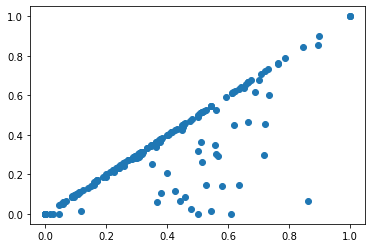

In [155]:
plt.scatter(cherb_df['cover_0m'], cherb_dict['coverherb_0m'])

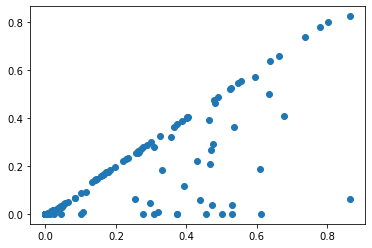

In [156]:
plt.scatter(cherb_df['cover_5cm'], cherb_dict['coverherb_5cm'])

In [47]:
coverd2.transpose().head()

,0.00,0.05,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,...,12.75,13.00,13.25,13.50,13.75,14.00,14.25,14.50,14.75,15.00
Mpala01-13,0.508197,0.163934,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mpala01-1,0.303571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mpala01-2,0.400000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mpala01-3,0.348837,0.255814,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mpala01-4,0.893939,0.863636,0.318182,0.045455,0.045455,0.030303,0.030303,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='nlayers', ylabel='Count'>

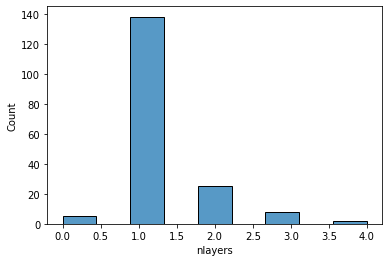

In [38]:
sns.histplot(complexity.loc["nlayers"])

<AxesSubplot:xlabel='herbh', ylabel='Count'>

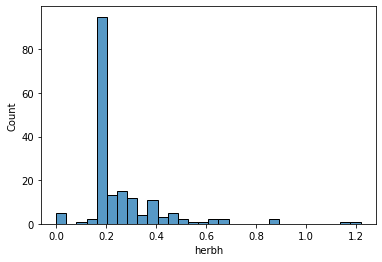

In [36]:
sns.histplot(complexity.loc["herbh"])

In [39]:
complexity.head()

,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
nlayers,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,2.000000,1.000000,3.000000,0,1.000000,1.000000,0,3.000000,0,1.000000
gapsize,0.000000,0.000000,0.000000,0.000000,1.250000,0.000000,0.000000,1.700000,0.000000,0.000000,...,1.950000,0.000000,2.200000,0,0.000000,0.000000,0,1.000000,0,0.000000
maxpeakh,0.050000,0.050000,0.050000,0.050000,1.500000,0.050000,0.050000,1.750000,0.050000,0.050000,...,2.000000,0.050000,3.000000,0,0.050000,0.050000,0,2.000000,0,0.050000
ptoh,0.607874,1.045707,0.659301,0.238313,1.151265,0.353347,0.589194,0.971465,0.058949,0.918483,...,0.982254,1.192676,1.086442,0,0.993917,1.194317,0,0.814945,0,1.227023
cscore,0.032258,0.032258,0.032258,0.032258,0.080645,0.032258,0.048387,0.096774,0.048387,0.048387,...,0.064516,0.016129,0.048387,0,0.032258,0.016129,0,0.112903,0,0.016129
